In [1]:
import ast
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import ruptures as rpt

# import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches

# import tensorflow libraries
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# import keras libraries
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import conformasegment as cs

C:\Users\ALMBT5A\AppData\Local\Temp\ipykernel_17940\1284989372.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [69]:
data = pd.read_csv('C:/Users/ALMBT5A/Desktop/conformasegment/Coffee_TRAIN.txt', header= None)
data = pd.DataFrame(data)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,277,278,279,280,281,282,283,284,285,286
0,0,-0.518419,-0.485884,-0.505007,-0.560183,-0.636299,-0.753229,-0.827229,-0.859765,-0.906321,...,-1.920125,-1.922313,-1.924212,-1.926997,-1.928721,-1.930026,-1.932301,-1.933631,-1.934964,-1.936007
1,0,-0.548462,-0.533681,-0.514723,-0.559256,-0.626806,-0.727284,-0.796339,-0.829552,-0.863091,...,-1.922542,-1.925779,-1.928604,-1.932173,-1.934748,-1.935731,-1.937072,-1.940727,-1.943786,-1.944308
2,0,-0.472634,-0.415546,-0.359929,-0.430496,-0.552132,-0.631621,-0.732572,-0.807120,-0.837240,...,-1.971076,-1.974600,-1.976788,-1.979676,-1.981696,-1.984215,-1.987586,-1.989143,-1.990659,-1.992301
3,0,-0.509521,-0.484218,-0.477951,-0.511287,-0.558587,-0.652428,-0.745298,-0.787356,-0.818280,...,-1.930869,-1.933198,-1.937328,-1.941241,-1.943985,-1.945762,-1.947613,-1.950172,-1.951748,-1.952922
4,0,-0.563427,-0.533896,-0.543822,-0.598246,-0.690260,-0.794384,-0.884140,-0.923970,-0.939504,...,-1.855820,-1.857870,-1.859198,-1.861003,-1.863121,-1.865041,-1.866122,-1.866945,-1.868419,-1.869571


In [70]:
labels = data.iloc[:,0]
data = data.iloc[:,1:]

In [71]:
mask = labels == 0  #we choose a specific time series type
data = data[mask]
labels = labels[mask]

In [72]:
training_set = np.array(data).flatten()

In [73]:
def df_to_XY(training_set,window_size=10):
 X_train=[]
 y_train=[]

 for i in range(235,len(training_set)):
    X_train.append(training_set[i-235:i])
    y_train.append(training_set[i])
    
 X_train, y_train = np.array(X_train), np.array(y_train)
 return X_train, y_train

WINDOW = 235
X,y = df_to_XY(training_set,WINDOW)
print(len(X),len(y))

3769 3769


In [74]:
# sample split
X_train = X[:600]
y_train = y[:600]
X_cal = X[800:1800]
y_cal = y[800:1800]
X_test = X[1800:2500]
y_test = y[1800:2500]


print(f"Train set: {len(X_train)}, {len(y_train)}")
print(f"Calibration set: {len(X_cal)}, {len(y_cal)}")
print(f"Test set: {len(X_test)}, {len(y_test)}")

Train set: 600, 600
Calibration set: 1000, 1000
Test set: 700, 700


In [75]:
#Reshaping(To add new dimensions)
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_cal = np.reshape(X_cal,(X_cal.shape[0],X_cal.shape[1],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [76]:
# make model
def make_lstm():
    regressor = Sequential()
    
    #Addinf the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units=100, return_sequences = True, input_shape=(X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))
    
    regressor.add(LSTM(units=100, return_sequences = True))
    regressor.add(Dropout(0.2))
    
    regressor.add(LSTM(units=100, return_sequences = True))
    regressor.add(Dropout(0.2))
    
    regressor.add(LSTM(units=100))
    regressor.add(Dropout(0.2))
    
    #Output layer
    regressor.add(Dense(units=1))
    
    regressor.compile(optimizer='adam',loss='mean_squared_error')
    
    return regressor

In [78]:
#fitting the rnn to the training set
regressor =make_lstm()
history=regressor.fit(X_train,y_train,epochs=10, batch_size=32)

Epoch 1/10
19/19 [==============================] - 15s 598ms/step - loss: 0.4161
Epoch 2/10
19/19 [==============================] - 12s 611ms/step - loss: 0.1810
Epoch 3/10
19/19 [==============================] - 13s 673ms/step - loss: 0.1420
Epoch 4/10
19/19 [==============================] - 13s 688ms/step - loss: 0.1265
Epoch 5/10
19/19 [==============================] - 13s 689ms/step - loss: 0.1181
Epoch 6/10
19/19 [==============================] - 13s 675ms/step - loss: 0.1125
Epoch 7/10
19/19 [==============================] - 13s 679ms/step - loss: 0.1020
Epoch 8/10
19/19 [==============================] - 13s 674ms/step - loss: 0.0995
Epoch 9/10
19/19 [==============================] - 13s 681ms/step - loss: 0.0981
Epoch 10/10
19/19 [==============================] - 13s 685ms/step - loss: 0.0696


In [79]:
predictions_original = regressor.predict(X_test[:700])

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions_original)
print(f"Mean Absolute Error (MAE): {mae}")

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions_original)
print(f"Mean Squared Error (MSE): {mse}")

from sklearn.metrics import r2_score
r2 = r2_score(y_test, predictions_original)
print(f"R² Score: {r2}")

22/22 [==============================] - 4s 130ms/step
Mean Absolute Error (MAE): 0.15976127106551072
Mean Squared Error (MSE): 0.05244581924776703
R² Score: 0.9420463744995773


In [80]:
# calibration

# Predict on calibration data
y_cal_pred = regressor.predict(X_cal).flatten()
# Absolute residuals
residuals = np.abs(y_cal - y_cal_pred)
alpha = 0.05  # 95% confidence level
q = np.quantile(residuals, 1 - alpha)

32/32 [==============================] - 4s 128ms/step


In [81]:
# Predict on test data
y_test_pred = regressor.predict(X_test[:700]).flatten()
# Prediction intervals
lower_bound = y_test_pred - q
upper_bound = y_test_pred + q
# Check if true values are within prediction intervals
in_interval = (y_test >= lower_bound) & (y_test <= upper_bound)

# Calculate coverage
coverage = np.mean(in_interval)  # Fraction of points within intervals
print(f"Coverage: {coverage * 100:.2f}%")

22/22 [==============================] - 3s 131ms/step
Coverage: 95.14%


32/32 [==============================] - 4s 127ms/step
[[-0.04481065]]
(0, 10)
(1, 235, 1)
32/32 [==============================] - 4s 130ms/step
[[-0.3904873]] [[0.30086595]]
(10, 15)
(1, 235, 1)
32/32 [==============================] - 4s 129ms/step
[[-0.39048728]] [[0.30086598]]
(15, 30)
(1, 235, 1)
32/32 [==============================] - 4s 129ms/step
[[-0.3904873]] [[0.30086595]]
(30, 60)
(1, 235, 1)
32/32 [==============================] - 4s 130ms/step
[[-0.39048713]] [[0.30086613]]
(60, 115)
(1, 235, 1)
32/32 [==============================] - 4s 127ms/step
[[-0.3904628]] [[0.30089048]]
(115, 205)
(1, 235, 1)
32/32 [==============================] - 4s 130ms/step
[[-0.35153]] [[0.33982328]]
(205, 225)
(1, 235, 1)
32/32 [==============================] - 4s 131ms/step
[[0.18875238]] [[0.8801056]]
(225, 235)
(1, 235, 1)
32/32 [==============================] - 4s 129ms/step
[[-0.54316026]] [[0.148193]]
[5.9604645e-08 0.0000000e+00 5.9604645e-08 2.9802322e-07 4.8995018e-05
 7.791

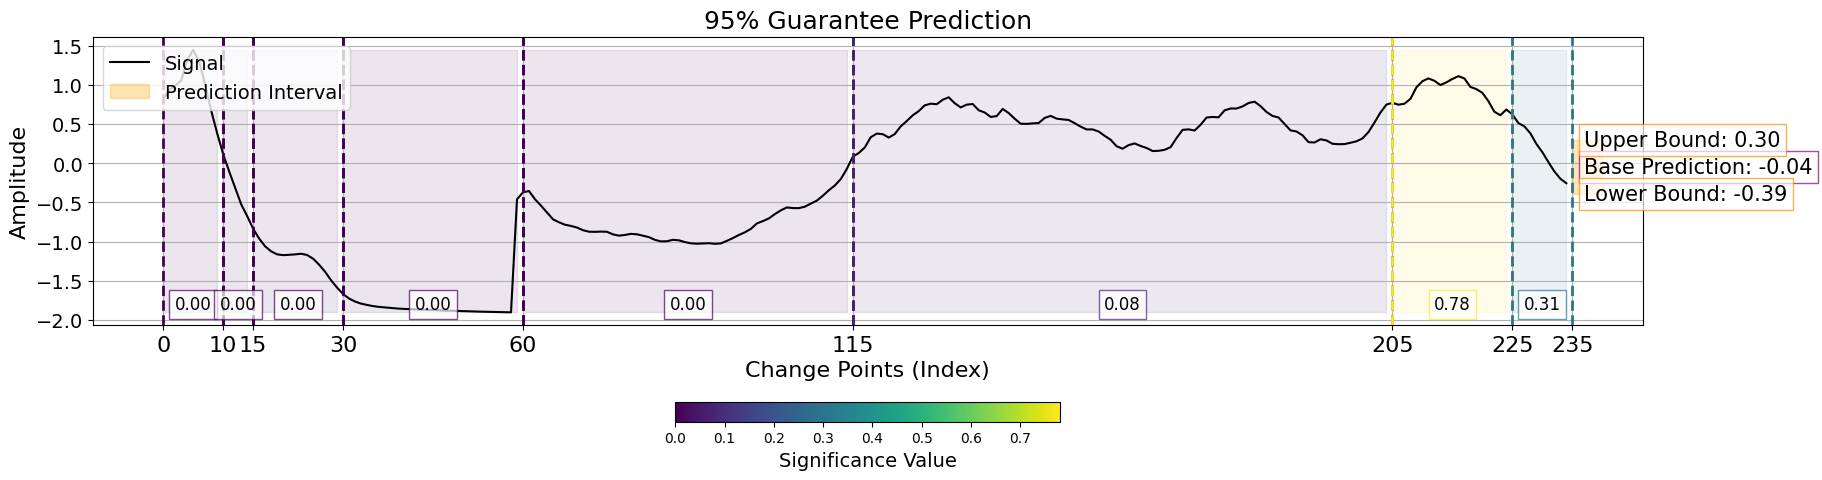

In [83]:
sample = X_test[143]
label_sample = y_test[143]

error_rate = 0.10
pelt_penalty_lambda = 2

cs.get_feature_importance(regressor, sample, label_sample, X_cal, y_cal, error_rate, pelt_penalty_lambda)